In [96]:
import psycopg2
import pandas as pd
import re 
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

In [75]:
#set pd display higher to be able to see lists for cleaning up
pd.options.display.max_rows = 100

In [76]:
#postgres connection
db_user = 'postgres'
db_password = ''
db_host = 'localhost'
db_port = 5432
database = 'met_data'

conn_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{database}'
conn = psycopg2.connect(conn_str)
conn.autocommit = True

In [77]:
#select object ID and name from object information and relevant image info from raw images
query = """SELECT 
            object_information.object_id,
            object_information.object_name,
            raw_images.id,
            raw_images.path,
            raw_images.x_pix,
            raw_images.y_pix
            FROM object_information
            JOIN raw_images
            ON object_information.object_id = raw_images.object_id
            WHERE object_information.object_name SIMILAR TO'%(V|v)ase%'
"""
raw_vases = pd.read_sql(query, con=conn)

In [78]:
#look at if any undesired objects made it into the df
raw_vases.object_name.value_counts()

Vase                                                                            4900
Covered vase                                                                      98
Toilet vase                                                                       49
Vase with cover                                                                   32
Celery vase                                                                       29
Apothecary vase                                                                   28
Flower vase                                                                       27
Vase fragment                                                                     20
Double vase                                                                       18
Vases                                                                             18
Pair of vases                                                                     16
Vase (bottom)                                                    

In [79]:
#only real issue is a number of items with fragment in the name that may not work well, so want to remove those
#list comprehension to get object names containg fragment
frags = [i for i in raw_vases.object_name.unique() if re.search(r'\W*(F|f)ragment*', i)]


In [80]:
#select all objects whose name are not in fragments list
raw_vases = raw_vases[~raw_vases.object_name.isin(frags)]

In [81]:
#create h/w ratio column to help decide what ratio to save images as
raw_vases['ratio'] =raw_vases.y_pix / raw_vases.x_pix

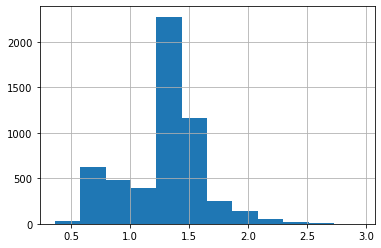

In [82]:
#plot ratio
raw_vases.ratio.hist(bins = 12)
plt.show()

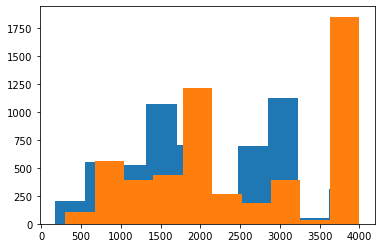

In [83]:
#plot h and w, together with ratio, will determine what size images are saved as
plt.hist(raw_vases.x_pix)
plt.hist(raw_vases.y_pix)
plt.show()

FileExistsError: [Errno 17] File exists: '/Users/spencer/Desktop/vase_image_data'

In [97]:
#based on the info provided above, decided to use images at a 5:4 ratio with h = 2000, w = 1600
#for ease of use with github, I reduced dimensions used to include a copy of the data under 100 mb
#halved in size 
new_dir = '/Users/spencer/Desktop/vase_image_data/'
for i in tqdm(range(len(raw_vases))):
    try:
        img = Image.open(raw_vases.path[i]).resize((384, 480))
        img.save(new_dir+f'vase_{raw_vases.id[i]}.jpg')
    except:
        print('image not found')

100%|█████████▉| 5420/5442 [26:43<00:08,  2.44it/s] 

image not found


100%|█████████▉| 5426/5442 [26:45<00:04,  3.48it/s]

image not found
image not found
image not found
image not found
image not found
image not found


100%|██████████| 5442/5442 [26:47<00:00,  3.39it/s]

image not found
image not found
image not found
image not found
image not found
image not found
image not found


In [98]:
import shutil
new_dir = '/Users/spencer/Desktop/vase_image_data'
shutil.make_archive('/Users/spencer/Desktop/vase_image_data', 'zip', new_dir)


'/Users/spencer/Desktop/vase_image_data.zip'